In [522]:
import cv2
import imutils
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from pytesseract import Output

In [523]:
def show(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.show()

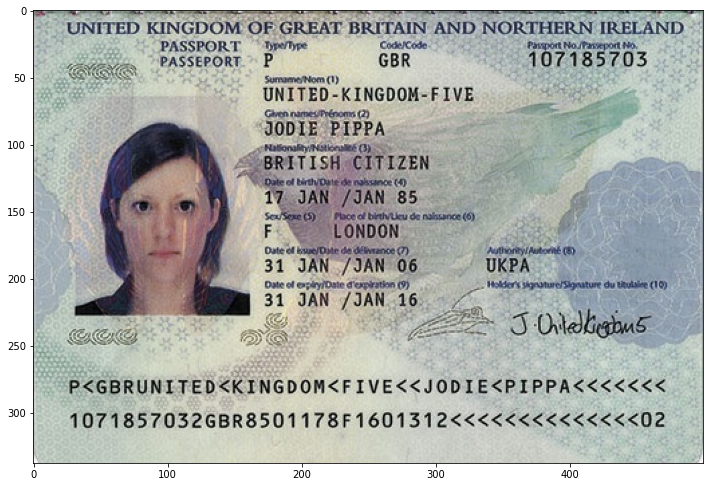

In [524]:
img = cv2.imread('id_examples/Sample_UK_Passports/Base.jpg')
img = img[:,:,::-1]
show(img)

After Gaussian Blur


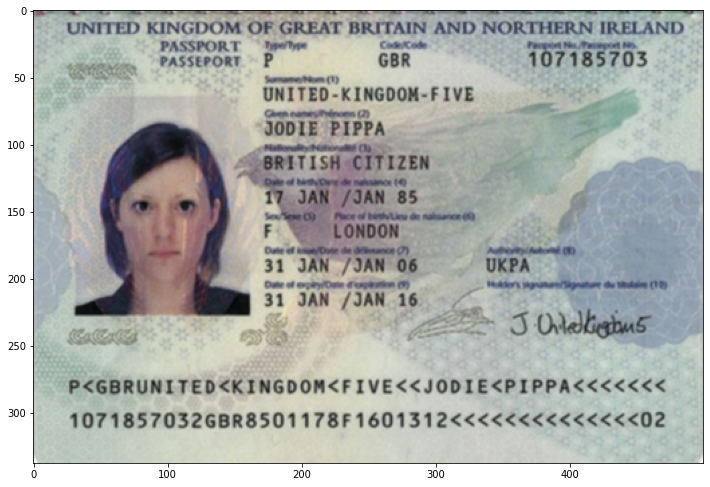

After Blackhat


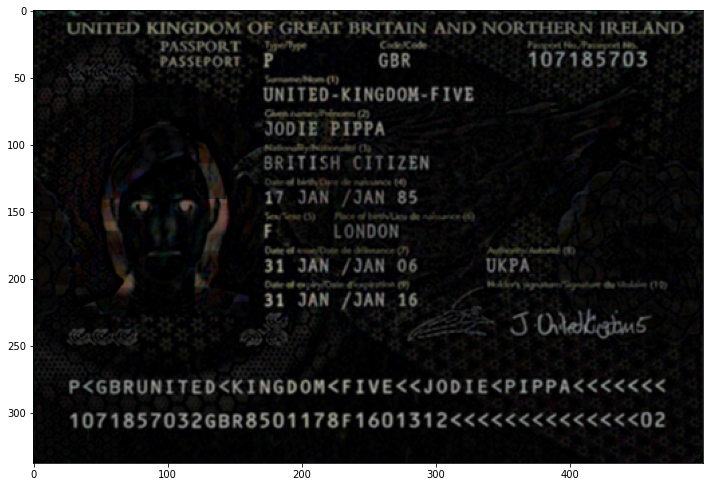

In [525]:
# smooth the image using a 3x3 Gaussian, then apply the blackhat
# morphological operator to find dark regions on a light background
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))

print('After Gaussian Blur')
gray = cv2.GaussianBlur(img, (3, 3), 0)
show(gray)

print('After Blackhat')
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
show(blackhat)

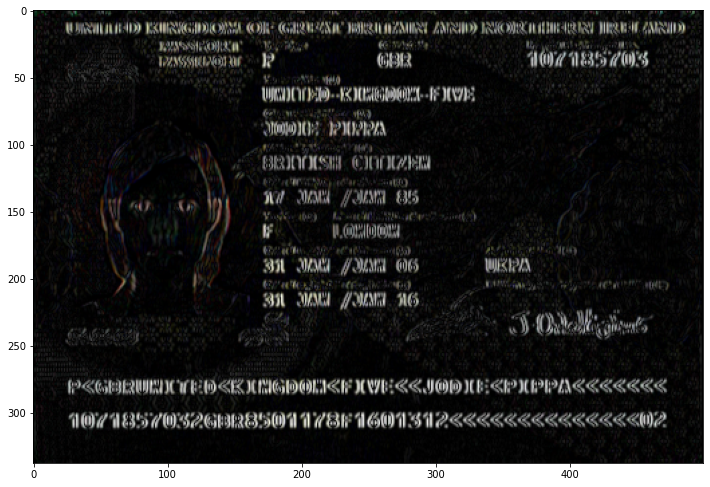

In [526]:
# compute the Scharr gradient of the blackhat image and scale the result into the range [0, 255]
# this is to detect strong vertical changes 
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
show(gradX)

AFTER CLOSING OPERATION


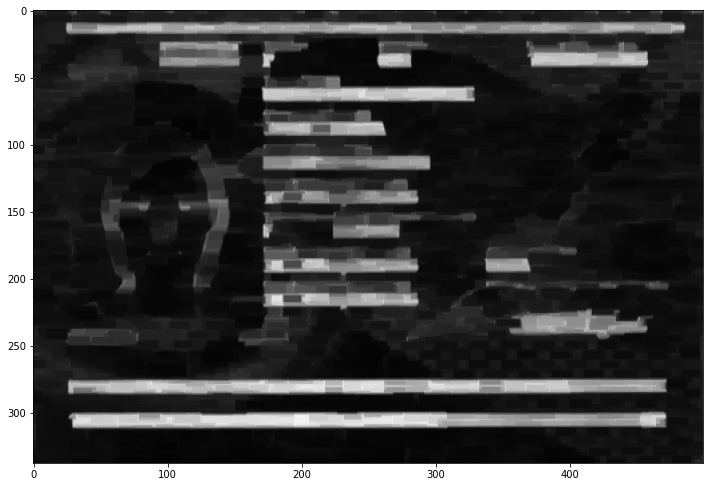

AFTER THRESHOLDING


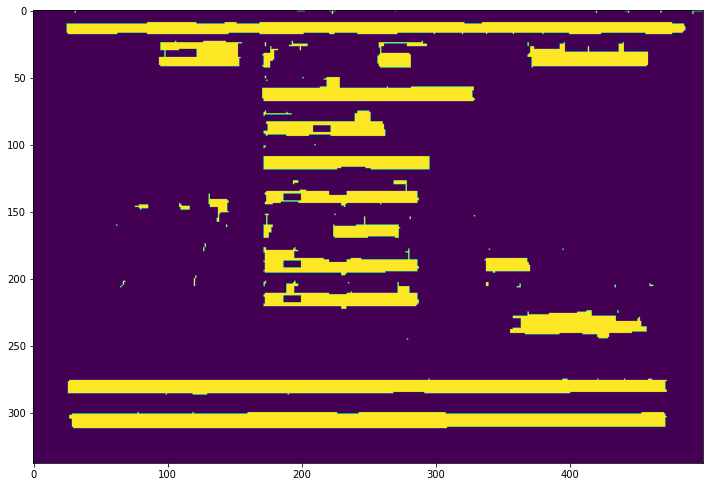

In [527]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
gradX = cv2.morphologyEx(cv2.cvtColor(gradX, cv2.COLOR_BGR2GRAY), cv2.MORPH_CLOSE, rectKernel)
print('AFTER CLOSING OPERATION')
show(cv2.cvtColor(gradX, cv2.COLOR_GRAY2BGR))
print('AFTER THRESHOLDING')
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
show(thresh)

NUMBER OF IDENTIFIED COUNTOURS AFTER APPLYING AREA FILTER:18 out of 56


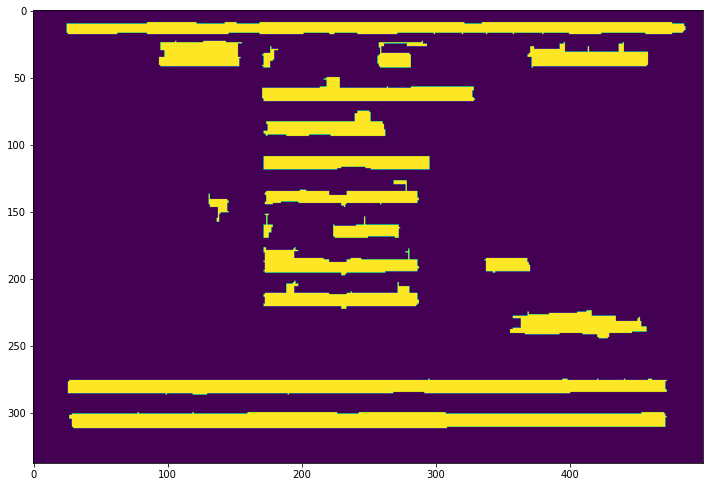

In [528]:
mask = np.zeros(gradX.shape, dtype=np.uint8)

# Find contours and filter using contour area
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
count = 0
filtered_countours = []
for c in cnts:
    # apply area to remove small blobs
    area = cv2.contourArea(c)
    if area > 25:
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        count += 1
        filtered_countours.append(c)

print("NUMBER OF IDENTIFIED COUNTOURS AFTER APPLYING AREA FILTER:" + str(count) + " out of " + str(len(cnts)))
show(mask)

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-529-7ca99d1bac0f>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


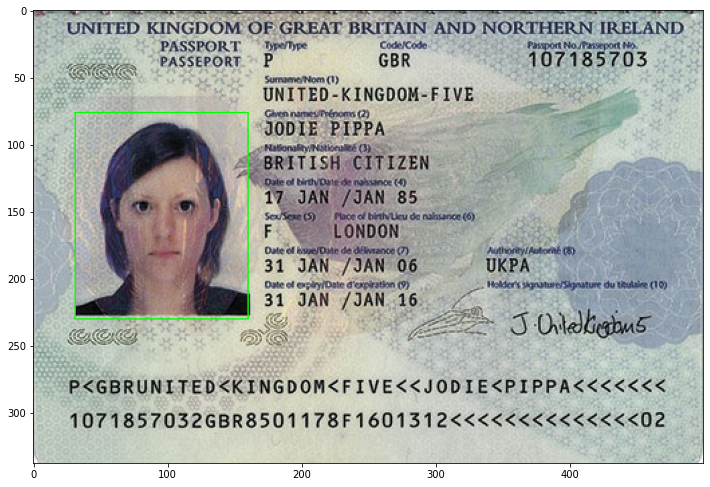

In [529]:
final_image = img.astype('int32') 

# We point OpenCV's CascadeClassifier function to where our 
# classifier (XML file format) is stored
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Our classifier returns the ROI of the detected face as a tuple
# It stores the top left coordinate and the bottom right coordiantes
faces = face_classifier.detectMultiScale(img, 1.3, 5)

# When no faces detected, face_classifier returns and empty tuple
if faces is ():
    print("No faces found")

# We iterate through our faces array and draw a rectangle
# over each face in faces
face_rectangle = []
for (x, y, w, h) in faces:
    x = x - 25 # Padding trick to take the whole face not just Haarcascades points
    y = y - 40 # Same here...
    cv2.rectangle(final_image, (x, y), (x + w + 45, y + h + 70), (0, 255, 0), 1)
    face_rectangle.append([(x, y), (x + w + 45, y + h + 70)])    

show(final_image)    

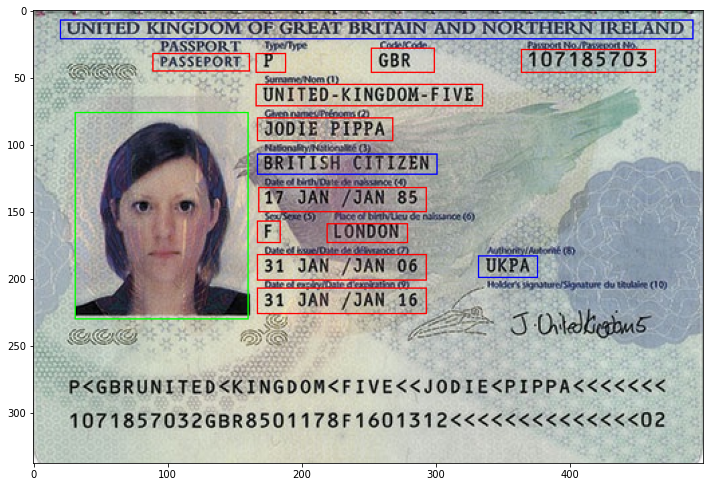

In [530]:
final_image_2 = final_image
# get the x and y range for the detected face. This is used for filtering out any blobs that 
# are identified within this range
face_width_range = range(face_rectangle[0][0][0], face_rectangle[0][0][0] + face_rectangle[0][1][0] - 20)
face_height_range = range(face_rectangle[0][0][1], face_rectangle[0][0][1] + face_rectangle[0][1][1])

roi_list = []

for c in filtered_countours:
    (x, y, w, h) = cv2.boundingRect(c)
    # to filter out any blobs within detected face
    if x in face_width_range and y in face_height_range or y > 250:
        continue
    else:        
        if x >= 350 and y > 220:
            continue    
        elif (x >= 90 and x <= 100) and (y <= 25):
            roi = final_image[y + 9 :y + h + 3, x - 5 :x + w + 5].copy()
            cv2.rectangle(final_image_2, (x - 5 , y + 9), (x + w + 5, y + h + 3), (255, 0, 0), 1)
            roi_list.append(roi)
        elif h >= 16:
            roi = final_image[y + 5 :y + h + 3, x - 5 :x + w + 5].copy()
            cv2.rectangle(final_image_2, (x - 5 , y + 5), (x + w + 5, y + h + 3), (255, 0, 0), 1)
            roi_list.append(roi)
        else:
            roi = final_image[y - 3 :y + h + 3, x:x + w].copy()
            cv2.rectangle(final_image_2, (x - 5, y - 2), (x + w + 5, y + h + 3), (0, 0, 255), 1)
            roi_list.append(roi)
show(final_image_2)

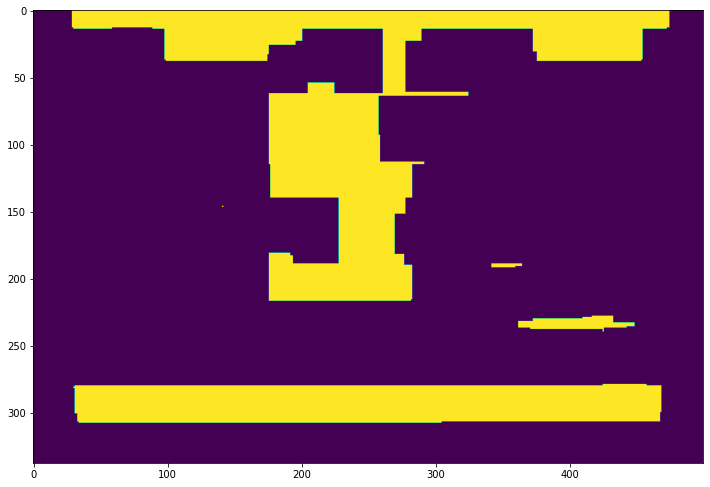

In [531]:
# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=4)

# during thresholding, it's possible that border pixels were
# included in the thresholding, so let's set 5% of the left and
# right borders to zero
p = int(gray.shape[1] * 0.05)
thresh[:, 0:p] = 0
thresh[:, gray.shape[1] - p:] = 0
show(thresh)

# find contours in the thresholded image and sort them by their size
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [532]:
mrz = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and use the contour to
    # compute the aspect ratio and coverage ratio of the bounding box
    # width to the width of the image
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    crWidth = w / float(gray.shape[1])

    # check to see if the aspect ratio and coverage width are within
    # acceptable criteria
    if ar > 5 and crWidth > 0.75:
        # pad the bounding box since we applied erosions and now need
        # to re-grow it
        pX = int((x + w) * 0.03)
        pY = int((y + h) * 0.03)
        (x, y) = (x - pX, y - pY)
        (w, h) = (w + (pX * 2), h + (pY * 2))

        # extract the ROI from the image and draw a bounding box
        # surrounding the MRZ
        roi = final_image_2[y-5:y + h+5, x:x + w].copy()
        cv2.rectangle(final_image_2, (x, y), (x + w, y + h), (0, 255, 0), 1)
        mrz.append(roi)
        break

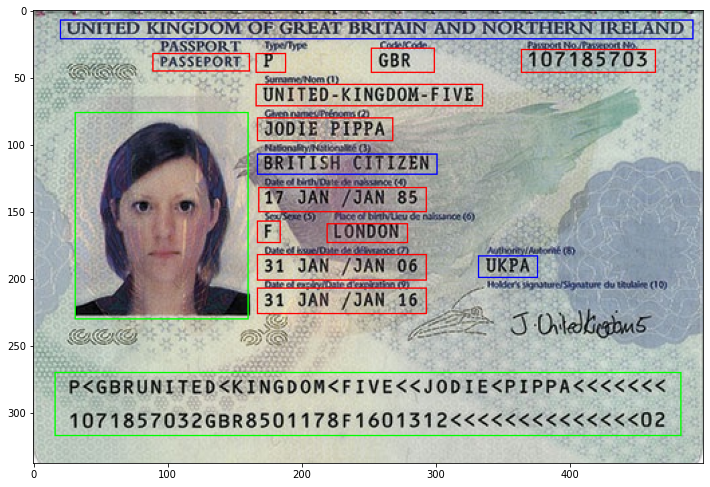

In [533]:
show(final_image_2)

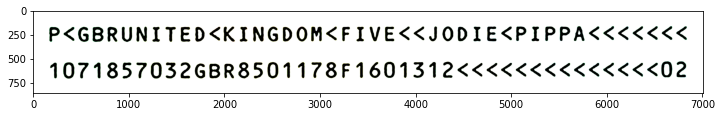

P<GBRUNITED<KINGDOMK<FIVE<<JODIE<PIPPA<<<<<<<1071857032GBR8501178F1601312<<<<<<<<<<<<<<02


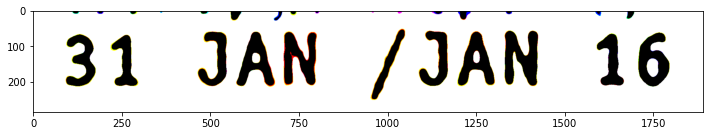

31 JAN /JAN 16



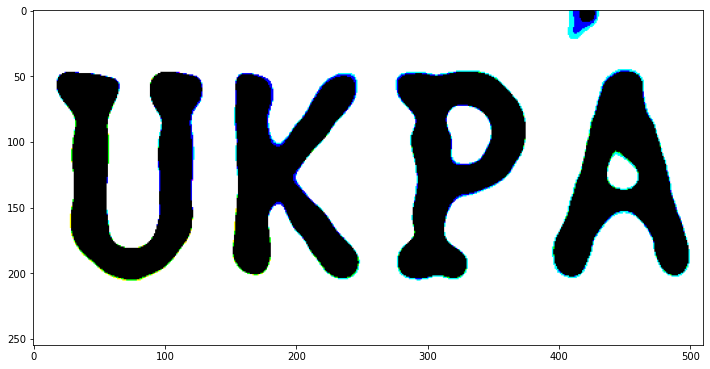

UKPA



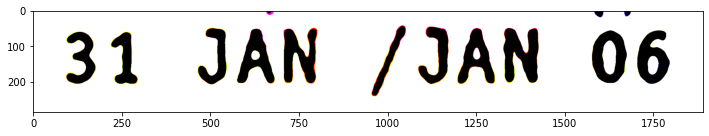

31 JAN /JAN 06



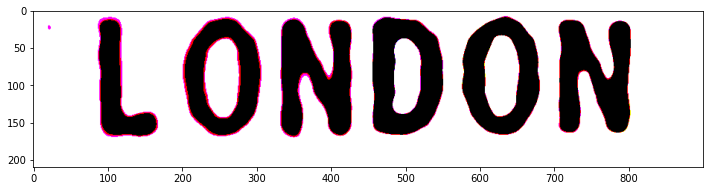

LONDON



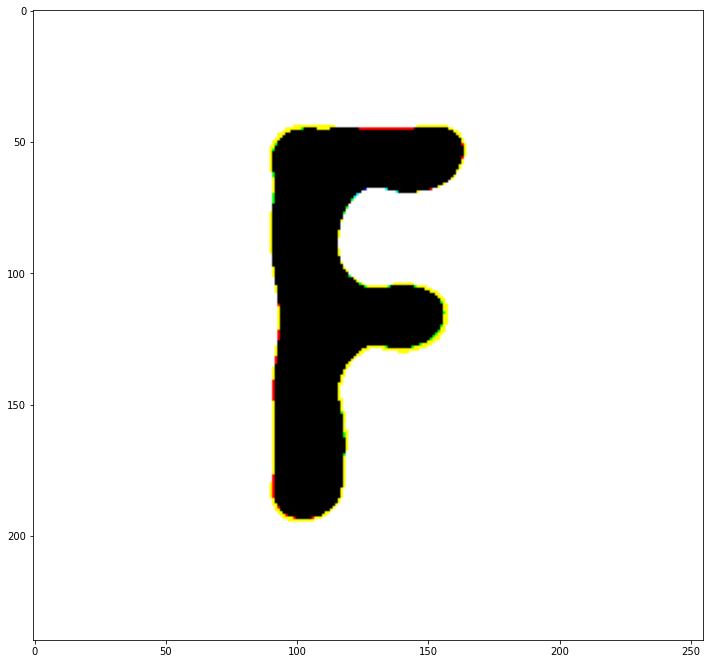

F



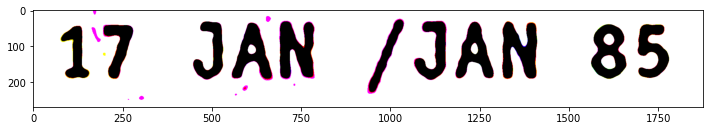

17 JAN /JAN 85



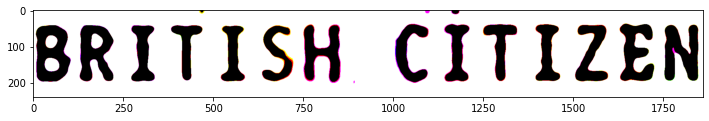

BRITISH CITIZEN



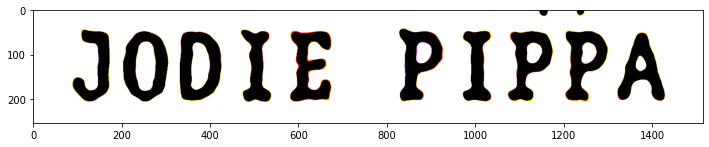

JODIE PIPPA



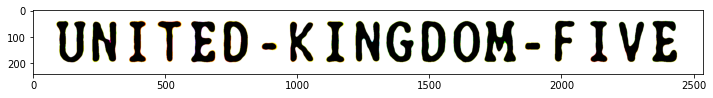

UNITED-KINGDOM-FIVE



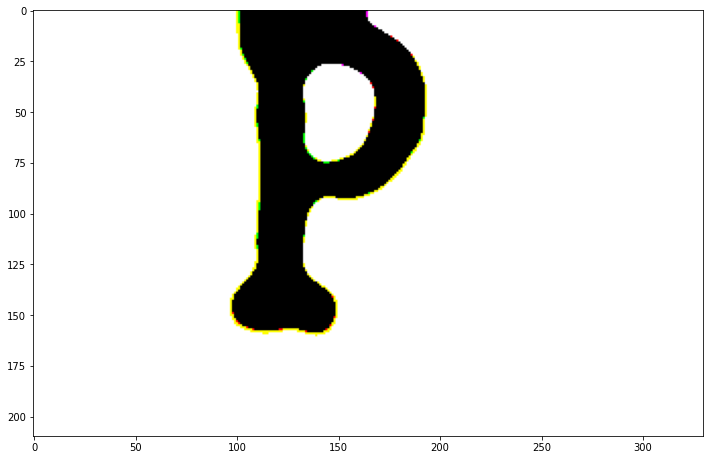

P



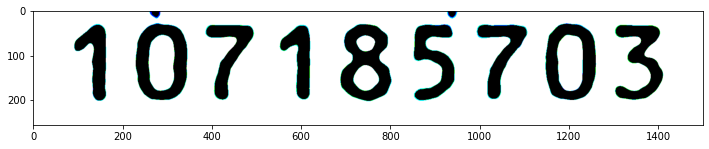

107185703



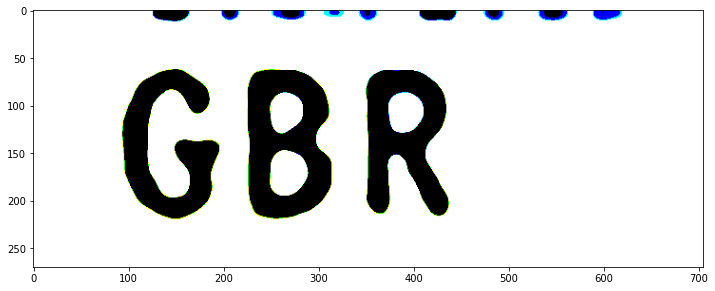

GBR



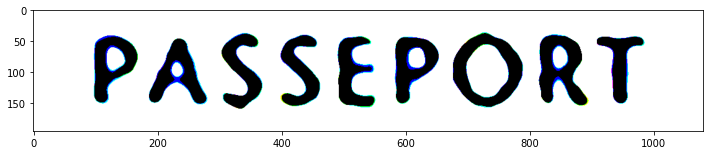

PASSEPORT



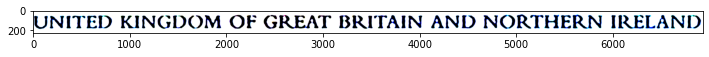

UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND



In [534]:
kernel = np.ones((7, 7), np.uint8)

resized = cv2.resize(mrz[0].astype('uint8'), None, fx = 15, fy = 15, interpolation=cv2.INTER_CUBIC)
_, thresh = cv2.threshold(resized, 100, 255, cv2.THRESH_BINARY)
show(thresh)
text = pytesseract.image_to_data(thresh, output_type=Output.DICT, lang='eng')
print("".join(text['text']))

for i in range(len(roi_list)):
    # INCREASE THE DPI by resizing and doing some interpolation
    resized = cv2.resize(roi_list[i].astype('uint8'), None, fx = 15, fy = 15, interpolation=cv2.INTER_CUBIC)
    # THRESHOLD
    _, thresh = cv2.threshold(resized, 100, 255, cv2.THRESH_BINARY)
    show(thresh)
    text = pytesseract.image_to_string(thresh, output_type=Output.DICT, lang='eng', config = "--psm 10")
    print(text['text'])   